# Entropy/Information-based EEG Classification (Motor Hands vs Feet)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne
from mne import Epochs, pick_types
from mne.channels import make_standard_montage
from mne.io import read_raw_edf, concatenate_raws

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import antropy as ant
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

root_dir = "../eeg-motor-movementimagery-dataset-1.0.0/files"

In [ ]:
def entropy_features_from_epochs(X, sfreq):
    """
    X: ndarray, shape (n_epochs, n_channels, n_times)
    Returns: ndarray, shape (n_epochs, n_channels * n_feats)
    Features per channel:
      - spectral_entropy (0.5-45 Hz) [computed from Welch PSD]
      - permutation entropy (AntroPy, if available)
      - sample entropy (AntroPy, if available)
      - Hjorth mobility & complexity
      - spectral flatness (Welch PSD)
    """
    n_epochs, n_channels, n_times = X.shape
    feats = []
    fmin, fmax = 0.5, min(45., sfreq/2 - 1e-3)
    nperseg = min(256, n_times)

    for ei in range(n_epochs):
        row = []
        for ci in range(n_channels):
            x = X[ei, ci]
            # z-score
            x = (x - np.mean(x)) / (np.std(x) + 1e-12)

            # Compute Welch PSD
            _, psd_se = mne.time_frequency.psd_array_welch(
                x, sfreq, n_per_seg=nperseg, fmin=fmin, fmax=fmax, verbose=False
            )
            p = psd_se / (np.sum(psd_se) + 1e-12)

            # Shannon entropy
            se = -np.sum(p * np.log2(p + 1e-12))
            se = se / (np.log2(len(p) + 1e-12))

            # permutation entropy
            pe = ant.perm_entropy(x, order=3, delay=1, normalize=True)

            # approximate entropy
            ae = ant.app_entropy(x, order=2, metric='chebyshev')

            # Renyi entropy (alpha=2)
            p_renyi = p[p > 0]
            alpha = 2.0
            renyi = np.log2(np.sum(p_renyi ** alpha)) / (1 - alpha)

            # Hjorth parameters
            mobility, complexity = ant.hjorth_params(x, axis=-1)

            # Detrended Fluctuation Analysis (DFA)
            dfa = ant.detrended_fluctuation(x)

            # Higuchi fractal dimension
            hfd = ant.higuchi_fd(x, kmax=10)

            # Petrosian fractal dimension
            pfd = ant.petrosian_fd(x)

            # katz fractal dimension
            kfd = ant.katz_fd(x)

            # sample entropy
            sae = ant.sample_entropy(x)

            row.extend([se, pe, ae, renyi, mobility, complexity, dfa, hfd, pfd, kfd, sae])
        feats.append(row)
    return np.asarray(feats)

In [ ]:
def process_subject_entropy(subject, classifier='knn', task_type='execution', n_csp_components=4, use_csp=True):
    tmin, tmax = -1.0, 4.0
    if task_type == 'execution':
        runs = [3, 7, 11]
    else:
        runs = [4, 8, 12]

    fnames = [f"{root_dir}/S{subject:03d}/S{subject:03d}R{r:02d}.edf" for r in runs]
    raw_list = []
    for f in fnames:
        if os.path.exists(f):
            raw_list.append(read_raw_edf(f, preload=True, verbose=False))
    if not raw_list:
        raise FileNotFoundError("No EDF files found for subject")
    raw = concatenate_raws(raw_list)

    mne.datasets.eegbci.standardize(raw)
    selected_chs = ['F3', 'Fz', 'F4', 'FC5', 'FC1', 'FC2', 'FC6', 'C3', 'C4', 'CP5', 'CP1', 'CP2', 'CP6', 'P3', 'Pz', 'P4']
    try:
        raw.pick(selected_chs)
    except Exception:
        pass
    montage = make_standard_montage("standard_1020")
    raw.set_montage(montage)
    raw.annotations.rename(dict(T1="hands", T2="feet"))
    raw.set_eeg_reference(projection=True)

    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge', verbose=False)
    raw.notch_filter(freqs=50., verbose=False)
    raw.notch_filter(freqs=60., verbose=False)
    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

    epochs = Epochs(raw, event_id=["hands", "feet"], tmin=tmin, tmax=tmax,
                    proj=True, picks=picks, baseline=None, preload=True, verbose=False)

    epochs_c = epochs.copy().crop(tmin=1.0, tmax=2.0)
    X = epochs_c.get_data()  # (n_epochs, n_channels, n_times)
    y = epochs.events[:, -1] - 2
    sf = epochs.info['sfreq']

    X_entropy = entropy_features_from_epochs(X, sf)  # shape (n_epochs, n_channels * n_feats)
    X_feat = X_entropy

    if classifier == 'knn':
        clf = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=5))])
    elif classifier == 'svm':
        clf = Pipeline([('scaler', StandardScaler()), ('svm', LinearSVC(C=1, random_state=42))])
    elif classifier == 'lda':
        clf = Pipeline([('scaler', StandardScaler()), ('lda', LinearDiscriminantAnalysis())])
    elif classifier == 'rf':
        clf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))])
    elif classifier == 'xgb':
        clf = Pipeline([('scaler', StandardScaler()), ('xgb', XGBClassifier(n_estimators=100, max_depth=6, n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'))])
    else:
        raise ValueError(f"Unknown classifier: {classifier}. Choose from 'knn','svm','lda','rf','xgb'.")

    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted')
    }

    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    scores = cross_validate(clf, X_feat, y, cv=cv, scoring=scoring, n_jobs=1)

    metrics = ['accuracy', 'precision', 'recall', 'f1']
    mean_scores = [np.mean(scores['test_' + m]) for m in metrics]
    std_scores = [np.std(scores['test_' + m]) for m in metrics]

    return {
        'metrics': metrics,
        'mean_scores': mean_scores,
        'std_scores': std_scores
    }

In [ ]:
subjects = [i for i in range(1, 110) if i not in [14, 34, 37, 41, 51, 64, 69, 72, 73, 74, 76, 88, 92, 100, 102, 104, 109]] 
classifiers = ['knn', 'svm', 'lda', 'rf', 'xgb']

results = []
for subj in subjects:
    for clf_name in classifiers:
        try:
            print(f"Classifier: {clf_name} on subject {subj}")
            r = process_subject_entropy(subj, classifier=clf_name, task_type='execution')
            results.append({
                'subject': subj,
                'classifier': clf_name,
                **{f"mean_{m}": ms for m, ms in zip(r['metrics'], r['mean_scores'])},
                **{f"std_{m}": ss for m, ss in zip(r['metrics'], r['std_scores'])}
            })
        except Exception as e:
            print(f"Subject {subj}, {clf_name}: {e}")

if results:
    df_res = pd.DataFrame(results)
    display(df_res)
    mean_accuracy = df_res['mean_accuracy'].mean()
    print(f"Overall mean accuracy across subjects: {mean_accuracy:.4f}")
else:
    print("No results computed. Check file paths and dependencies (antropy).")

Classifier: knn on subject 1
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Classifier: svm on subject 1
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Classifier: svm on subject 1
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Classifier: lda on subject 1
EEG channel type selected

,subject,classifier,mean_accuracy,mean_precision,mean_recall,mean_f1,std_accuracy,std_precision,std_recall,std_f1
0,1,knn,0.600000,0.742910,0.600000,0.563680,0.073703,0.114456,0.073703,0.080319
1,1,svm,0.500000,0.500794,0.500000,0.482892,0.133795,0.167651,0.133795,0.138042
2,1,lda,0.533333,0.502028,0.533333,0.502309,0.163299,0.215251,0.163299,0.179533
3,1,rf,0.622222,0.642394,0.622222,0.610388,0.150718,0.156363,0.150718,0.152085
4,1,xgb,0.544444,0.549021,0.544444,0.532583,0.126198,0.145360,0.126198,0.125387
...,...,...,...,...,...,...,...,...,...,...
455,108,knn,0.522222,0.509603,0.522222,0.499227,0.131937,0.166204,0.131937,0.143477
456,108,svm,0.688889,0.713426,0.688889,0.681891,0.129577,0.138775,0.129577,0.131084
457,108,lda,0.444444,0.431852,0.444444,0.427648,0.149071,0.181129,0.149071,0.161661
458,108,rf,0.500000,0.478986,0.500000,0.472499,0.089581,0.108040,0.089581,0.090160


Overall mean accuracy across subjects: 0.5367


In [72]:
# Calculate mean value of all metrics for the five models across all subjects
metrics = ['mean_accuracy', 'mean_precision', 'mean_recall', 'mean_f1']
mean_metrics = df_res.groupby('classifier')[metrics].mean()
mean_metrics['min_accuracy'] = df_res.groupby('classifier')['mean_accuracy'].min()
mean_metrics['max_accuracy'] = df_res.groupby('classifier')['mean_accuracy'].max()
display(mean_metrics)

,mean_accuracy,mean_precision,mean_recall,mean_f1,min_accuracy,max_accuracy
classifier,,,,,,
knn,0.518852,0.522103,0.518852,0.497364,0.277778,0.755556
lda,0.553656,0.561637,0.553656,0.538541,0.311111,0.811111
rf,0.537615,0.543449,0.537615,0.521045,0.333333,0.766667
svm,0.539756,0.546640,0.539756,0.524800,0.333333,0.900000
xgb,0.533388,0.538971,0.533388,0.518490,0.333333,0.788889


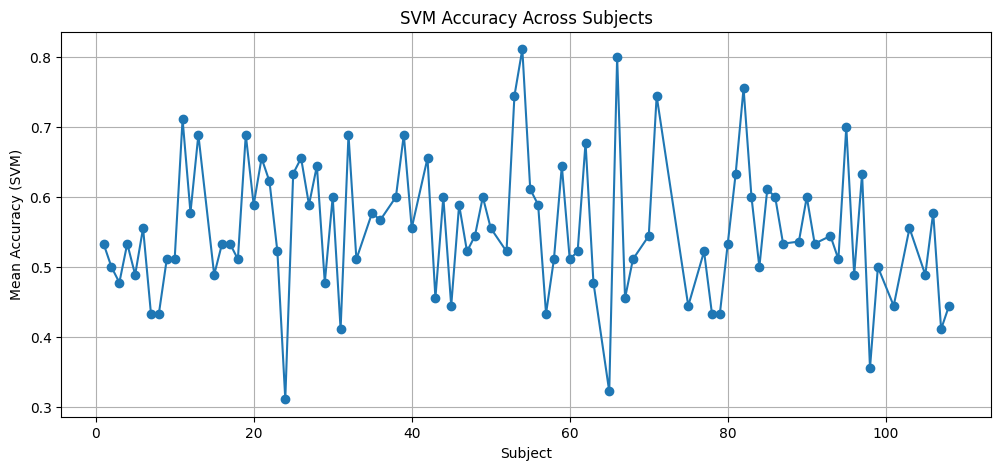

In [87]:
svm_acc = df_res[df_res['classifier'] == 'lda'][['subject', 'mean_accuracy']]
plt.figure(figsize=(12, 5))
plt.plot(svm_acc['subject'], svm_acc['mean_accuracy'], marker='o', linestyle='-')
plt.xlabel('Subject')
plt.ylabel('Mean Accuracy (SVM)')
plt.title('SVM Accuracy Across Subjects')
plt.grid(True)
plt.show()